# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.shape

(891221, 85)

In [6]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SOHO_KZ,person,ordinal,[-1]
freq,1,43,49,26


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.

feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
def parse_missing_info(value):
    """
    Parses "missing_or_unknown" field in the feat_info dataset
    """
    
    value = value.replace("[", "").replace("]", "")
    value = value.split(",")
    
    if len(value) == 1 and value[0] == "":
        return []
    
    return value

In [11]:
for i, row in feat_info.iterrows():
    missing_info = row["missing_or_unknown"]
    missing_info = parse_missing_info(missing_info)

    attr = row["attribute"]
    
    if missing_info:
        for info in missing_info:
            try:
                info = int(info)
            except:
                pass
            
            # most identifiers are numbers, but there are also
            # some string, like "xx"

            mask = azdias[attr] == info    
            azdias.loc[mask, attr] = np.nan       

In [12]:
azdias_describe = azdias.describe()
azdias_describe

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

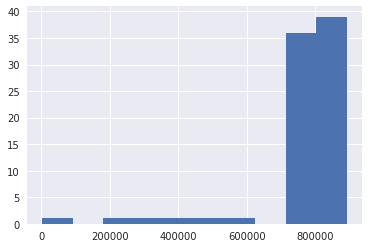

In [13]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

sns.set()

azdias_describe.loc["count", :].hist()

In [14]:
# Investigate patterns in the amount of missing data in each column.

azdias_describe.loc["count", :].sort_values().describe()

count        81.000000
mean     792668.839506
std      150223.314859
min        2160.000000
25%      774706.000000
50%      798073.000000
75%      891221.000000
max      891221.000000
Name: count, dtype: float64

In [15]:
azdias_describe.loc["count", :].sort_values().head(15)

TITEL_KZ            2160.0
AGER_TYP          205378.0
KK_KUNDENTYP      306609.0
KBA05_BAUMAX      414697.0
GEBURTSJAHR       498903.0
ALTER_HH          580954.0
KKK               733157.0
REGIOTYP          733157.0
W_KEIT_KIND_HH    743233.0
KBA05_GBZ         757897.0
KBA05_ANTG2       757897.0
KBA05_ANTG1       757897.0
MOBI_REGIO        757897.0
KBA05_ANTG4       757897.0
KBA05_ANTG3       757897.0
Name: count, dtype: float64

In [16]:
azdias_count = pd.DataFrame(azdias_describe.loc["count", :])

mask = azdias_count["count"] <= 700000
azdias_count[mask]

,count
AGER_TYP,205378.0
GEBURTSJAHR,498903.0
TITEL_KZ,2160.0
ALTER_HH,580954.0
KK_KUNDENTYP,306609.0
KBA05_BAUMAX,414697.0


In [17]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

cols_to_remove = azdias_count[mask].index
cols_to_remove = list(cols_to_remove)
cols_to_remove

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [18]:
azdias = azdias.drop(columns=cols_to_remove)

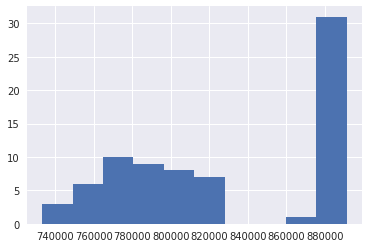

In [19]:
azdias.describe().loc["count", :].hist()

#### Discussion 1.1.2: Assess Missing Data in Each Column

The first histogram shows a great density of features whose count sits around **800,000** records, but also a very few columns with a count on the **0 < x < 700,000** range.

By looking at the 25% quantile, we can also check that, by that mark, the are already seeing a number very close to the **mean** (which is **~792,668**). This reinforces the assertion that **<= 700,00** is a **good filter** to detect and remove outliers.

Finally, a look on the actual counts, sorted in a asceding manner, clearly shows that we have **6 outlier columns**, and then again confirms that <= 700,00 is a good mask for this.

By applying the mask, we get a list of our outlying columns:

1. AGER_TYP
2. GEBURTSJAHR
3. TITEL_KZ
4. ALTER_HH
5. KK_KUNDENTYP
6. KBA05_BAUMAX

After the removal of this columns, a second histogram shows that now our counts are more balanced

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [20]:
# How much data is missing in each row of the dataset?

azdias_count_na_rows = azdias.isna().sum(axis=1)

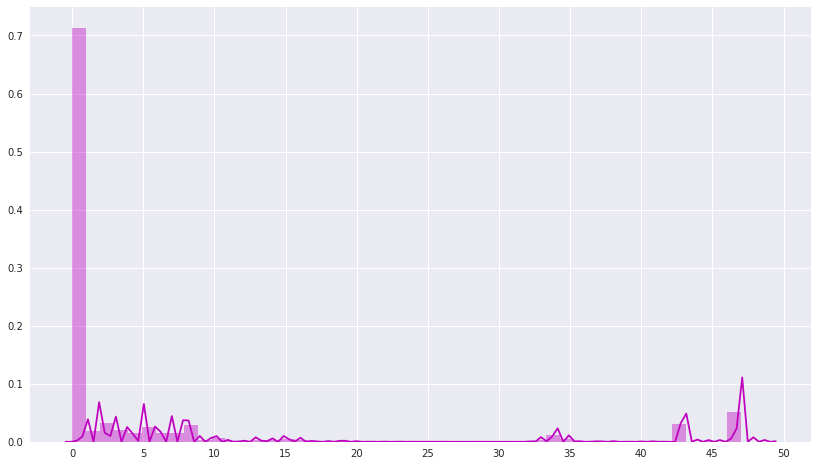

In [21]:
plt.figure(figsize=(14,8))
plt.xticks(np.arange(0,55,5))
sns.distplot(azdias_count_na_rows, color="m", kde=True, hist=True);

In [22]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

threshold = 12
count_na_df = pd.DataFrame(azdias_count_na_rows, columns=["count"])

In [23]:
mask = count_na_df["count"] == 0
print("Rows with no missing values:",
      count_na_df[mask].shape[0],
      "({:.2f}%)".format((count_na_df[mask].shape[0]/count_na_df.shape[0])*100))

Rows with no missing values: 623209 (69.93%)


In [24]:
mask = count_na_df["count"] <= threshold
dense_set = count_na_df[mask]
dense_set = azdias.iloc[dense_set.index, :]

print("Rows in the dense set:",
      dense_set.shape[0],
      "({:.2f}%)".format((dense_set.shape[0]/count_na_df.shape[0])*100))

Rows in the dense set: 782046 (87.75%)


In [25]:
mask = count_na_df["count"] > threshold
rare_set = count_na_df[mask]
rare_set = azdias.iloc[rare_set.index, :]

print("Rows in the rare set:",
      rare_set.shape[0],
      "({:.2f}%)".format((rare_set.shape[0]/count_na_df.shape[0])*100))

Rows in the rare set: 109175 (12.25%)


In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

max_count = azdias_count["count"].max()
mask = azdias_count["count"] == max_count

all_cols = azdias_count[mask].index
all_cols = list(all_cols)

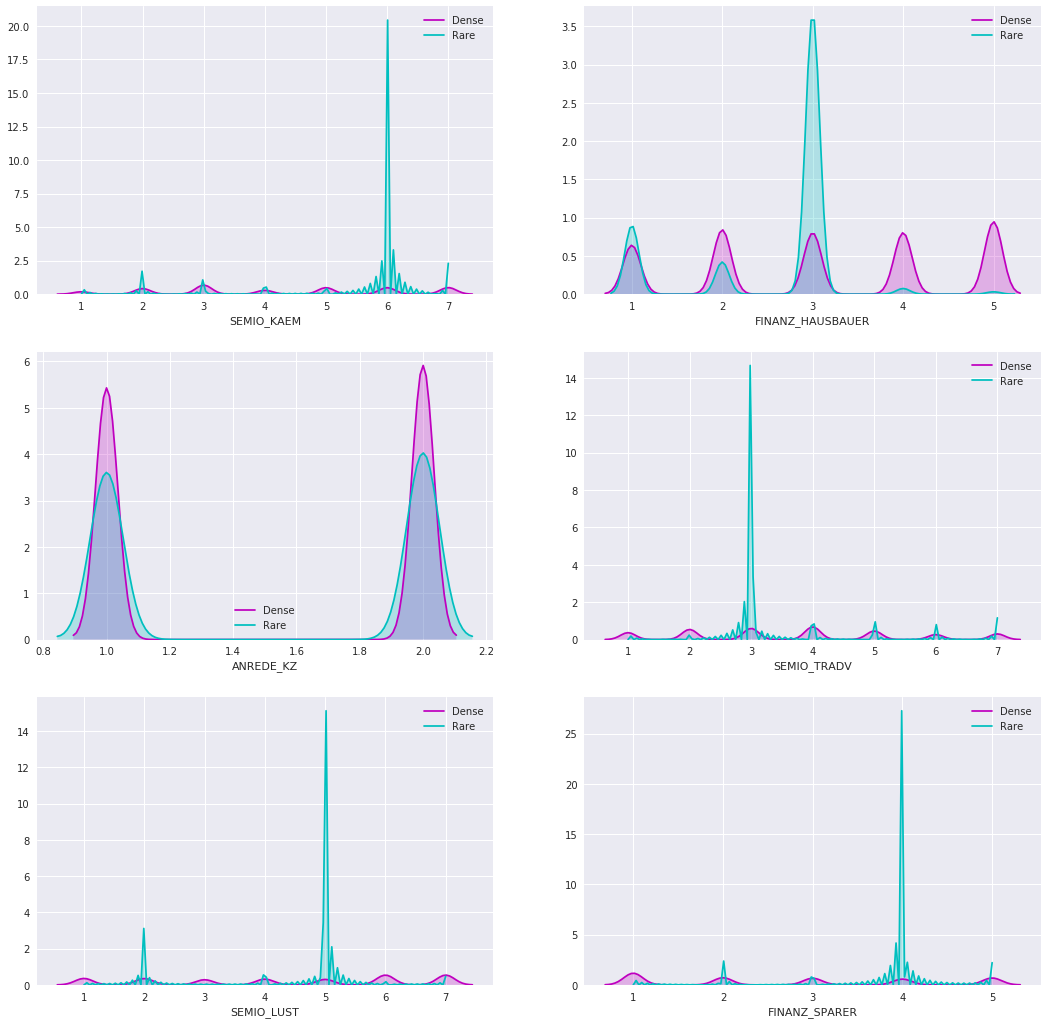

In [27]:
cols = random.sample(all_cols, 6)

fig, axes = plt.subplots(3, 2, figsize=(18, 18))

line_count = 0
col_count = 0
for i in range(6):
    sns.distplot(dense_set[cols[i]],
                 hist=False,
                 color="m",
                 ax=axes[line_count, col_count],
                 label="Dense",
                 kde_kws={"shade": True})

    sns.distplot(rare_set[cols[i]],
                 hist=False,
                 color="c",
                 ax=axes[line_count, col_count],
                 label="Rare",
                 kde_kws={"shade": True})

    line_count += 1

    if line_count > 2:
        line_count = 0
        col_count += 1

In [28]:
dense_set["FINANZ_VORSORGER"].value_counts()

5.0    232762
4.0    188992
3.0    149827
2.0    109733
1.0    100732
Name: FINANZ_VORSORGER, dtype: int64

In [29]:
rare_set["FINANZ_VORSORGER"].value_counts()

3.0    80015
5.0     9500
4.0     9226
2.0     6797
1.0     3637
Name: FINANZ_VORSORGER, dtype: int64

#### Discussion 1.1.3: Assess Missing Data in Each Row

The first histogram, showing the distribution of missing values in rows, seems to point to up to **5 clusters**:

1. rows with **0 to 12** missings values;
2. **12 to 17**;
3. **32 to 37**;
4. **42 to 45**;
5. finally, **45 to 50**.

Since the objective is to separate in only two groups, one of them being the subset with few or no missing data, then te appropriat limit is **12**. Rows with 12 or less missing values formed the **dense set**, while rows with more than 12 rows formed the **rare set**.

To compare both subsets, we took all columns with no missing values, randomly chose 6 of them and then compared the frequencies of values for each column. By doing this, we can see that there is a starking difference between these sets. The **dense set** has more uniform distributions, while the **rare set** seems to give a much higher preference to single value for each column.

This discrepance might indicate some relationships that may be explored in the future. But for now, we will continue with the **dense set**.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [30]:
# How many features are there of each data type?

feat_info["type"].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [31]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

mask = feat_info["type"] == "categorical"

cat_attrs = feat_info[mask]["attribute"]
cat_attrs = cat_attrs.values
cat_attrs = list(cat_attrs)

cat_attrs = [col for col in cat_attrs if col in dense_set.columns]
len(cat_attrs)

18

In [32]:
for cat in cat_attrs:
    if cat in dense_set.columns:
        print(cat, dense_set[cat].unique())

ANREDE_KZ [ 2.  1.]
CJT_GESAMTTYP [  5.   3.   2.   4.   1.   6.  nan]
FINANZTYP [ 1.  6.  5.  2.  4.  3.]
GFK_URLAUBERTYP [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
GREEN_AVANTGARDE [0 1]
LP_FAMILIE_FEIN [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
LP_FAMILIE_GROB [  3.   1.  nan   5.   2.   4.]
LP_STATUS_FEIN [  2.   3.   9.   4.   1.  10.   5.   8.   6.   7.  nan]
LP_STATUS_GROB [  1.   2.   4.   5.   3.  nan]
NATIONALITAET_KZ [  1.   3.   2.  nan]
SHOPPER_TYP [  3.   2.   1.   0.  nan]
SOHO_KZ [ 1.  0.]
VERS_TYP [  2.   1.  nan]
ZABEOTYP [ 5.  3.  4.  1.  6.  2.]
GEBAEUDETYP [ 8.  1.  3.  2.  6.  4.  5.]
OST_WEST_KZ ['W' 'O']
CAMEO_DEUG_2015 ['8' '4' '2' '6' '1' '9' '5' '7' '3' nan]
CAMEO_DEU_2015 ['8A' '4C' '2A' '6B' '8C' '4A' '2D' '1A' '1E' '9D' '5C' '8B' '7A' '5D' '9E'
 '9B' '1B' '3D' nan '4E' '4B' '3C' '5A' '7B' '9A' '6D' '6E' '2C' '7C' '9C'
 '7D' '5E' '1D' '8D' '6C' '6A' '5B' '4D' '3A' '2B' '7E' '3B' '6F' '5F' '1C']


In [33]:
keep_these = ["ANREDE_KZ", "GREEN_AVANTGARDE", "SOHO_KZ", "VERS_TYP"]
convert_to_numeric = ["OST_WEST_KZ"]
convert_to_dummy = [col for col in cat_attrs if col not in keep_these and col not in convert_to_numeric]

In [34]:
len(convert_to_dummy)

13

In [35]:
# Re-encode categorical variable(s) to be kept in the analysis.

dense_set[convert_to_numeric[0]] = dense_set[convert_to_numeric[0]].replace({"W": 0, "O": 1})

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [36]:
print(dense_set.columns)
print(len(dense_set.columns))

for col in convert_to_dummy:
    dense_set_dummy = pd.concat([
        dense_set,
        pd.get_dummies(dense_set[col], prefix=col, dtype=int)
    ], sort=False)
    break
    
print(dense_set_dummy.columns)

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [37]:
dense_set = dense_set.drop(columns=convert_to_dummy)

In [38]:
dense_set.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


#### Discussion 1.2.1: Re-Encode Categorical Features

The initial dataset had 21 categorical features. After removing the columns with much missing data, we ended up with **18** categorial features.

Four of these features (`ANREDE_KZ, GREEN_AVANTGARDE, SOHO_KZ, VERS_TYP`) are binary with numeric values, meaning that we can keep them the way they are.

`OST_WEST_KZ` was the only binary non-numeric feature. Its values were simply replaced by numeric ones, thus making it appropriate for our analysis.

The 13 remaning features were, in the end, dropped from our analysis. Even tought we could deal with them via one-hot encoding, most of these features had many possible values, meaning that we would end up with a incredibly large dataset. To keep things straightforward, these columns were dropped.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [39]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

mainstream = [1, 3, 5, 8, 10, 12, 14]
mask_mainstream = dense_set["PRAEGENDE_JUGENDJAHRE"].isin(mainstream)
mask_avantgard = dense_set["PRAEGENDE_JUGENDJAHRE"].isin(mainstream) == False

dense_set.loc[mask_mainstream, "PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = 0
dense_set.loc[mask_avantgard, "PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = 1

In [40]:
decade = {
    "40": [1, 2], #1
    "50": [3, 4], #2
    "60": [5, 6, 7], #3
    "70": [8, 9], #4
    "80": [10, 11, 12, 13], #5
    "90": [14, 15] #6
}

i = 1
for d, n in decade.items():
    mask = dense_set["PRAEGENDE_JUGENDJAHRE"].isin(n)
    dense_set.loc[mask, "PRAEGENDE_JUGENDJAHRE_DECADE"] = i
    
    i += 1

In [41]:
dense_set["PRAEGENDE_JUGENDJAHRE_DECADE"].value_counts()

6.0    219902
4.0    172285
5.0    148421
3.0    113336
2.0     73553
1.0     27779
Name: PRAEGENDE_JUGENDJAHRE_DECADE, dtype: int64

In [42]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

dense_set["CAMEO_INTL_2015_WEALTH"] = dense_set["CAMEO_INTL_2015"].str[0]
dense_set["CAMEO_INTL_2015_LIFE_STAGE"] = dense_set["CAMEO_INTL_2015"].str[1]

In [43]:
cols = ["CAMEO_INTL_2015", "CAMEO_INTL_2015_WEALTH", "CAMEO_INTL_2015_LIFE_STAGE"]
dense_set[cols].head()

,CAMEO_INTL_2015,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,51,5,1
2,24,2,4
3,12,1,2
4,43,4,3
5,54,5,4


In [44]:
# Now, to have a look on other mixed type features

mask = feat_info["type"] == "mixed"
feat_info[mask]

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
64,KBA05_BAUMAX,microcell_rr3,mixed,"[-1,0]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


In [45]:
# LP_LEBENSPHASE_GROB

dense_set = pd.concat([
    dense_set,
    pd.get_dummies(dense_set["LP_LEBENSPHASE_GROB"], prefix="LP_LEBENSPHASE_GROB", dtype=int)
], sort=False, axis=1)

dense_set = dense_set.drop(columns=["LP_LEBENSPHASE_GROB"])

In [46]:
# LP_LEBENSPHASE_FEIN

dense_set = dense_set.drop(columns=["LP_LEBENSPHASE_FEIN"])

#### Discussion 1.2.2: Engineer Mixed-Type Features

`PRAEGENDE_JUGENDJAHRE` and `CAMEO_INTL_2015` were treated as requested, distangling their meanings into other columns.

`WOHNLAGE`, considering its nature as explained in the data dictionary, may be taken, for keeping things straightforward, as a ordinal feature.

`KBA05_BAUMAX, PLZ8_BAUMAX`, in the same spirit, may be taken as interval features.

`LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` are more difficult ones and each received a different treatment. 

`LP_LEBENSPHASE_GROB` has up to three meanings: **age**, **earnings** and **life stage**. However, it is really difficult to distangle them, as these three meanings are not always available on all of the possible values. Also, some values carry more than a single possibility for each meanings. Example: `7 - single low-income and average earner families`. Thus, it was treated as a categorial feature, for which dummy variables were created.

For `LP_LEBENSPHASE_FEIN`, we also see the same issues that `LP_LEBENSPHASE_GROB` faced. But this time, we have many more possible values. If we were to also create dummy variables, we would add 40 new columns to out dataset. So, to keep things simply, this feature was dropped.

It is also important to notice that both `LP_LEBENSPHASE_GROB` and `LP_LEBENSPHASE_FEIN` are talking about the _Lebensphase_, that is, the life stage of every person. The first is in a rough scale, the latter is in a fine scale. Since we kept the first, we are not really losing this information. We are simply not getting it in a so detailed manner.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [47]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

dense_set.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S', 'SEMIO_SOZ',
       'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST',
       'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM',
       'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_INTL_2015',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW',
       'PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANT

In [48]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

dense_set = dense_set.drop(columns=["CAMEO_INTL_2015", "PRAEGENDE_JUGENDJAHRE"])

In [49]:
dense_set.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'KBA05_ANTG1',
       'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM',
       'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_HHZ'

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [50]:
def convert_to_nans(df, feat_info):
    """
    Convert missing values to NaNs
    Missing values are indicated by the 'feat_info' dataset
    """
    
    for i, row in feat_info.iterrows():
        missing_info = row["missing_or_unknown"]
        missing_info = parse_missing_info(missing_info)
        # 'parse_missing_info' was defined earlier in the notebook

        attr = row["attribute"]

        if missing_info:
            for info in missing_info:
                try:
                    info = int(info)
                except:
                    pass

                # most identifiers are numbers, but there are also
                # some string, like "xx"

                mask = df[attr] == info    
                df.loc[mask, attr] = np.nan
    
    return df

In [51]:
def remove_cols_with_nans(df):
    """
    Removes columns that are known to have too much missing data
    """
    
    df = df.drop(columns=[
        "AGER_TYP",
        "GEBURTSJAHR",
        "TITEL_KZ",
        "ALTER_HH",
        "KK_KUNDENTYP",
        "KBA05_BAUMAX"
    ])
    
    return df

In [52]:
def remove_rows_with_nans(df, threshold):
    """
    Removes rows in which the count of missing values is above the threshold
    """
    
    df["_NAN_COUNT"] = df.isna().sum(axis=1)
    mask = df["_NAN_COUNT"] <= threshold
    
    df = df[mask]
    df = df.drop(columns=["_NAN_COUNT"])
    
    return df

In [53]:
def appropriate_categorial_features(df, feat_info):
    """
    Perform appropriations on the categorial features, such as
    converting a non-numeric binary column to a numeric binary column
    """

    mask = feat_info["type"] == "categorical"
    
    cat_attrs = feat_info[mask]["attribute"]
    cat_attrs = list(cat_attrs.values)
    cat_attrs = [col for col in cat_attrs if col in df.columns]
    
    keep = ["ANREDE_KZ", "GREEN_AVANTGARDE", "SOHO_KZ", "VERS_TYP", "OST_WEST_KZ"]
    drop = [col for col in cat_attrs if col not in keep]
        
    # columns in the drop list have too many values and would expand our dataset too much
    # that's why they are being dropped
    df = df.drop(columns=drop)
    
    # 'OST_WEST_KZ' is a binary column with non-numeric values
    # these will be replaced by numeric ones
    df["OST_WEST_KZ"] = df["OST_WEST_KZ"].replace({"W": 0, "O": 1})
    
    # the remaining columns are already appropriate for our analysis
    return df

In [54]:
def appropriate_mixed_features(df):
    """
    Performs appropriations on the mixed features, such as
    distangling certain meanings of specific columns
    """
    
    # PRAEGENDE_JUGENDJAHRE
    
    mainstream = [1, 3, 5, 8, 10, 12, 14]
    mask_mainstream = df["PRAEGENDE_JUGENDJAHRE"].isin(mainstream)
    mask_avantgard = df["PRAEGENDE_JUGENDJAHRE"].isin(mainstream) == False

    df.loc[mask_mainstream, "PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = 0
    df.loc[mask_avantgard, "PRAEGENDE_JUGENDJAHRE_MOVEMENT"] = 1
    
    decade = {
        "40": [1, 2], #1
        "50": [3, 4], #2
        "60": [5, 6, 7], #3
        "70": [8, 9], #4
        "80": [10, 11, 12, 13], #5
        "90": [14, 15] #6
    }

    i = 1
    for d, n in decade.items():
        mask = df["PRAEGENDE_JUGENDJAHRE"].isin(n)
        df.loc[mask, "PRAEGENDE_JUGENDJAHRE_DECADE"] = i
        i += 1
    
    # CAMEO_INTL_2015
    
    df["CAMEO_INTL_2015_WEALTH"] = df["CAMEO_INTL_2015"].str[0]
    df["CAMEO_INTL_2015_LIFE_STAGE"] = df["CAMEO_INTL_2015"].str[1]
    
    # LP_LEBENSPHASE_GROB

    df = pd.concat([
        df,
        pd.get_dummies(df["LP_LEBENSPHASE_GROB"], prefix="LP_LEBENSPHASE_GROB", dtype=int)
    ], sort=False, axis=1)
    
    # discard  "LP_LEBENSPHASE_FEIN" and drop original columns that were converted
   
    df = df.drop(columns=[
        "PRAEGENDE_JUGENDJAHRE",
        "CAMEO_INTL_2015",
        "LP_LEBENSPHASE_GROB",
        "LP_LEBENSPHASE_FEIN"
    ])

    return df

In [55]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    df = df.copy()
    # since some cleaning tasks will be done using .loc, these will be inplace
    # since I do not want this function to mess with the original dataset
    # we will use a copy of it
    
    # deals with missing data
    df = convert_to_nans(df, feat_info)
    df = remove_cols_with_nans(df)
    df = remove_rows_with_nans(df, 12)
        
    # select, re-encode, and engineer column values
    df = appropriate_categorial_features(df, feat_info)
    df = appropriate_mixed_features(df)

    # Return the cleaned dataframe.
    return df

In [56]:
azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=";")
feat_info_test = pd.read_csv("AZDIAS_Feature_Summary.csv", sep=";")

In [57]:
test = clean_data(azdias_test, feat_info_test)
test

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0,0,0,1,0,0,0,0,0,0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0,0,0,0,0,0,0,1,0,0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0,0,0,0,0,0,0,0,0,0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,0,0,0,0,0,0,0,0,0,0
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,1,0,0,0,0,0,0,0,0,0
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,0,0,0,0,0,0,0,0,0,0
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0,2.0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
test.shape, dense_set.shape

((782046, 78), (782046, 78))

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [59]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now

dense_count = dense_set.describe().loc["count", :]
dense_count.value_counts().max() / dense_count.shape[0]

0.56578947368421051

In [60]:
imp = Imputer(missing_values=np.nan, strategy="mean")
data = imp.fit_transform(dense_set)

In [61]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
data = scaler.fit_transform(data)

In [62]:
test = pd.DataFrame(data, columns=dense_set.columns)
test.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0
count,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,...,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05,7.820460e+05
mean,-7.512775e-16,1.043946e-17,1.469156e-16,3.276300e-17,1.133712e-16,-2.961935e-18,1.293802e-17,9.935202e-17,-8.813119e-18,-1.165512e-16,...,3.617695e-17,1.722647e-17,-5.878441e-17,2.525822e-18,-9.476374e-18,-4.174420e-17,3.884132e-18,-1.810778e-17,-5.471402e-17,1.177505e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.767309e+00,-1.043621e+00,-1.488579e+00,-1.151067e+00,-1.771766e+00,-1.247921e+00,-1.173185e+00,-1.531261e+00,-5.309937e-01,-1.630938e+00,...,-3.947139e-01,-2.629838e-01,-2.486237e-01,-1.878430e-01,-1.652169e-01,-1.893771e-01,-2.487281e-01,-2.255848e-01,-2.014832e-01,-3.102862e-01
25%,-7.842587e-01,-1.043621e+00,-7.629781e-01,-1.151067e+00,-1.045335e+00,-1.247921e+00,-1.173185e+00,-8.165605e-01,-5.309937e-01,-2.759488e-01,...,-3.947139e-01,-2.629838e-01,-2.486237e-01,-1.878430e-01,-1.652169e-01,-1.893771e-01,-2.487281e-01,-2.255848e-01,-2.014832e-01,-3.102862e-01
50%,1.987920e-01,9.582026e-01,-3.737737e-02,1.940370e-01,4.075271e-01,1.094767e-01,-4.557711e-01,-1.018599e-01,-5.309937e-01,-2.759488e-01,...,-3.947139e-01,-2.629838e-01,-2.486237e-01,-1.878430e-01,-1.652169e-01,-1.893771e-01,-2.487281e-01,-2.255848e-01,-2.014832e-01,-3.102862e-01
75%,1.181843e+00,9.582026e-01,6.882233e-01,8.665888e-01,1.133958e+00,7.881755e-01,9.790559e-01,6.128408e-01,-5.309937e-01,1.079040e+00,...,-3.947139e-01,-2.629838e-01,-2.486237e-01,-1.878430e-01,-1.652169e-01,-1.893771e-01,-2.487281e-01,-2.255848e-01,-2.014832e-01,-3.102862e-01
max,1.181843e+00,9.582026e-01,1.413824e+00,1.539141e+00,1.133958e+00,1.466874e+00,1.696469e+00,1.327541e+00,1.883261e+00,1.079040e+00,...,2.533481e+00,3.802515e+00,4.022143e+00,5.323595e+00,6.052648e+00,5.280470e+00,4.020455e+00,4.432923e+00,4.963193e+00,3.222831e+00


### Discussion 2.1: Apply Feature Scaling

Even though we already have cleaned some of the missing data, by looking at rows and columns that had too many `NaNs` and dropping them, our dataset still had some incomplete information.

Adopting a strict approach, that is, discarding every column that has at least one missing value, does not seem to be the best answer here. Even after the initial cleanup, only **56.58%** or our dataset is fully complete. By keeping only full columns, we would lose nearly half of our dataset.

A better strategy is to use an `Imputer`. By looking at the **mean** of every feature, we could fill all missing values. With a complete dataset, we could finally apply the scalling with the `StandardScaler`.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [63]:
# Apply PCA to the data.

pca = PCA()
data_pca = pca.fit_transform(data)

In [64]:
# Investigate the variance accounted for by each principal component.

def show_pca(pca):
    comps = pca.explained_variance_ratio_
    cum_comps = np.cumsum(comps)
    
    ticks = np.arange(1, len(comps)+1)
    ticks_ = np.arange(0, len(comps)+5, 5)
    
    yticks_ = np.arange(0, 1.1, 0.1)

    plt.figure(figsize=(16,6))
    plt.bar(ticks, comps, color="g", label="individual explained variance")
    plt.plot(ticks, cum_comps, color="c", linestyle="--", label="cumulative explained variance")
    plt.xticks(ticks_)
    plt.yticks(yticks_)
    plt.legend();

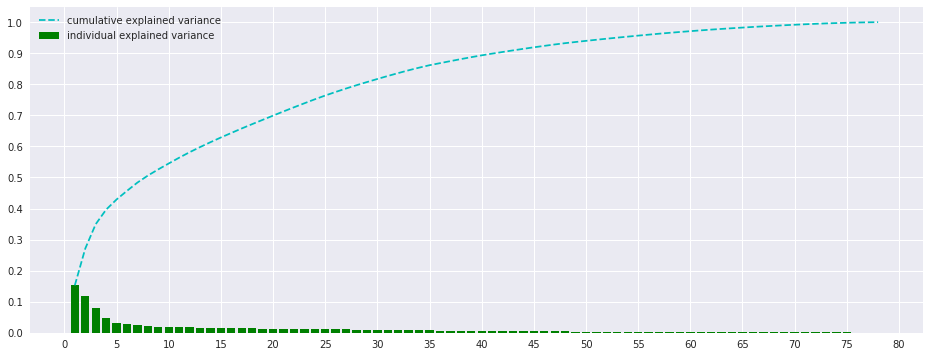

In [65]:
show_pca(pca)

In [66]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(8)
data_pca = pca.fit_transform(data)

### Discussion 2.2: Perform Dimensionality Reduction

The PCA plot shows that, by the **eighth** dimension, we are already explaning **50%** of our data. Thus being, we will continue our analysis with 8 principal components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [67]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

pca_dims = pd.DataFrame(pca.components_, columns = dense_set.columns)
pca_dims.index = ["dimension {}".format(i) for i in range(len(pca.components_))]

pca_dims

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_LEBENSPHASE_GROB_3.0,LP_LEBENSPHASE_GROB_4.0,LP_LEBENSPHASE_GROB_5.0,LP_LEBENSPHASE_GROB_6.0,LP_LEBENSPHASE_GROB_7.0,LP_LEBENSPHASE_GROB_8.0,LP_LEBENSPHASE_GROB_9.0,LP_LEBENSPHASE_GROB_10.0,LP_LEBENSPHASE_GROB_11.0,LP_LEBENSPHASE_GROB_12.0
dimension 0,-0.099530,0.010561,-0.206286,0.126444,-0.096329,0.053178,0.059646,0.161958,-0.100990,0.025822,...,-0.085365,0.032816,-0.072469,0.004909,0.015398,-0.050239,0.030318,0.016298,-0.042025,-0.101063
dimension 1,0.259079,0.068694,0.086671,-0.242612,0.237970,-0.211173,-0.229556,0.098521,-0.005478,-0.056572,...,0.016080,0.028166,0.018628,-0.038913,-0.044729,-0.039318,-0.090573,0.058354,-0.076096,0.028838
dimension 2,0.058976,-0.372273,0.152862,-0.089255,0.083559,-0.173761,-0.082859,-0.054114,0.048953,-0.014691,...,0.035920,0.009298,0.027916,-0.052710,-0.023368,-0.008006,-0.031926,0.007049,-0.005678,0.023329
dimension 3,-0.031410,0.034430,0.073291,-0.002823,-0.016527,-0.112546,0.079261,-0.112924,0.373052,0.002164,...,-0.000221,-0.023443,0.042507,0.008931,0.021279,0.065679,0.015966,-0.012926,0.075854,0.083144
dimension 4,0.024830,0.002483,0.080757,-0.007815,-0.048518,0.061169,-0.070057,-0.081231,-0.003285,0.004837,...,-0.090833,-0.003432,0.015888,0.033904,0.059403,0.077340,0.078494,0.071638,0.104337,0.142508
dimension 5,0.054162,-0.019048,-0.045314,0.012782,0.041200,0.040561,-0.016012,0.018698,-0.060073,-0.019624,...,-0.289427,0.058092,-0.068452,0.066167,0.128328,0.106488,0.162950,0.189011,0.091039,0.153010
dimension 6,-0.011812,0.027487,-0.020423,0.001409,-0.045123,0.002990,-0.014698,0.038249,0.050534,-0.031724,...,0.039521,-0.020337,0.036738,-0.020729,-0.041729,-0.000642,-0.044691,-0.079499,-0.000558,-0.044201
dimension 7,-0.037135,-0.052857,0.073674,0.031980,-0.001710,0.018275,0.045499,-0.190740,-0.038921,0.272304,...,0.115751,-0.096759,0.027664,0.021279,-0.039851,0.022007,-0.080081,-0.087495,0.025924,-0.028282


In [68]:
def show_pca_dim(pca, df, dim_num, features_num = 8):
    """
    Plots the most interesting features of a principal component
    
    Inputs:
        pca: a fitted PCA object
        df: the original dataset that was provided for the PCA
        dim_num: the number of the component you wish to see, 0-indexed
        features_num: the number of features to show on each side of the plot. Default is 8
        
    Outputs:
        None
    """
    
    pca_df = pd.DataFrame(pca.components_, columns = df.columns)
    
    negative = pca_df.iloc[dim_num, :].sort_values().head(features_num)
    positive = pca_df.iloc[dim_num, :].sort_values().tail(features_num)

    concat = pd.concat([negative, positive])

    plt.figure(figsize=(16,8))
    sns.barplot(x = concat.index, y = concat.values, palette="rocket")
    plt.xticks(rotation=90);    
    plt.title("Dimension {}".format(dim_num), fontsize=16);

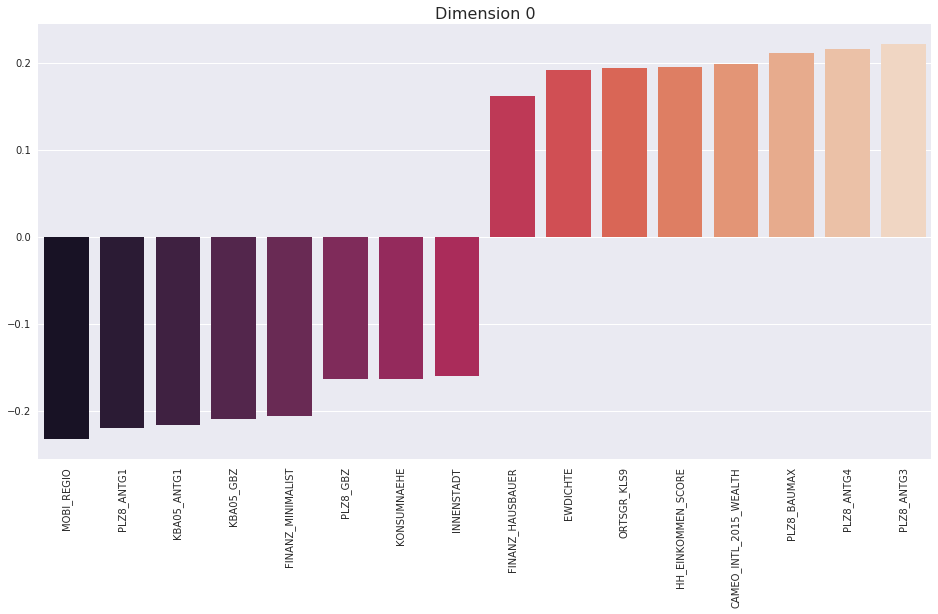

In [69]:
show_pca_dim(pca, dense_set, 0)

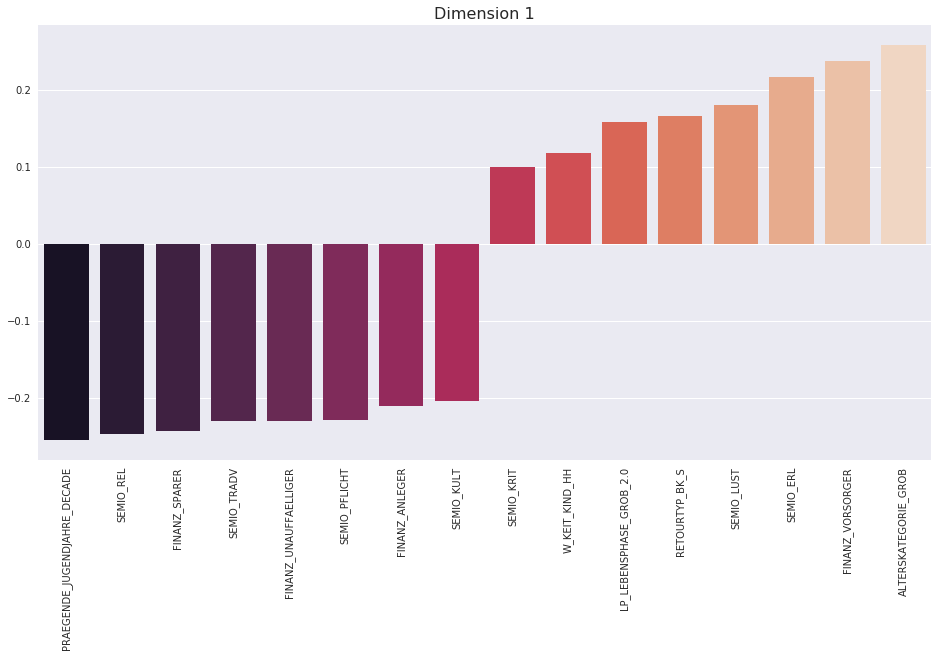

In [70]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca_dim(pca, dense_set, 1)

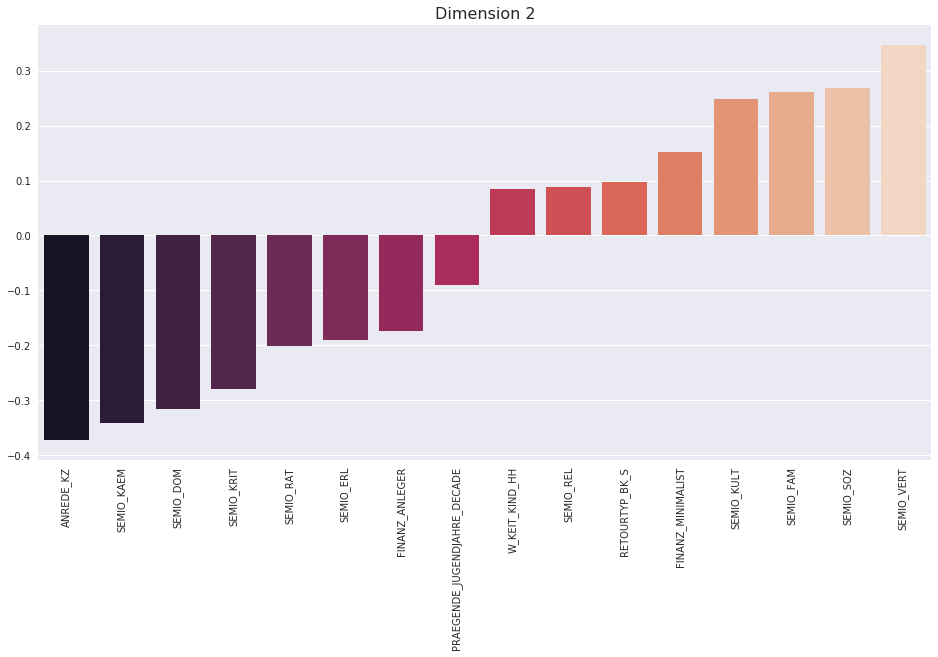

In [71]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

show_pca_dim(pca, dense_set, 2)

### Discussion 2.3: Interpret Principal Components

#### First component

The first component ("Dimension 0") tells much about the **living conditions** of an individual. The `PLZ8_*` features are very prominent, on both spectrums. These features indicate the number of family houses in the postal region of the person. Each `PLZ8_ANTG*` indicate a bigger family the bigger the number in the feature's name. `PLZ8_BAUMAX` works like an aggregation of these, indicating the main size of families in the region. Thus being, **bigger families have a bigger weight on this component**.

Smaller families and `MOBI_REGION` have a **negative weight** on this region. `MOBI_REGION` indicate "movement patterns" and the _lower_ the score, the _higher_ the movement. So **less crowded** areas have a **negative feedback** on this component.

Considering that features with opposite weights have an inverse correlation, this makes a lot of sense. Basically, the component is telling how crowded is the region that the individual lives in. 


#### Second component

The second component ("Dimension 1") mixes **age and economics**. Positive weights are on `ALTERSKATEGORIE_GROB` ("estimated age based on given name analysis", the _higher_ the value, the _older_ the individual) and `FINANZ_VORSORGER` ("financial typology: be prepared", the _lower_ the score, the _higher_ the affinity).

On the other end, we see negative weights for `PRAEGENDE_JUGENDJAHRE_DECADE` (the distangled decade information from `PRAEGENDE_JUGENDJAHRE`, the lower the value indicating an older decade) and `SEMIO_REL` (how religious an individual is, the _lower_ the score, the _higher_ the affinity. We also see `FINANZ_SPARER` ("financial typology: money saver", then again with the inverted score).

We can see that this component describes older individuals, that save money but do not get into investments.


#### Third component

Our dimension 2 brings about most of the `SEMIO_*` features. These features indicate a **personality trait**, with _lower score_ meaning _higher affinity_ with that trait. On the **positive** side, we see `SEMIO_VERT`, `SEMIO_SOZ` and `SEMIO_FAM`, indicating, respectively, _dreamfull_, _socially-minded_ and _family-minded_. On the **negative** side, we see `SEMIO_KAEM`, `SEMIO_DOM` and `SEMIO_KRIT`: _combative attitude_, _dominant-minded_ and _critical-minded_.

This component is all about the balance between emotional and rational individuals, giving higher values to the latter.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [78]:
# Over a number of different cluster counts...
# run k-means clustering on the data and... 
# compute the average within-cluster distances.

In [72]:
model_2 = KMeans(2, random_state=42)
labels = model_2.fit_predict(data_pca)
print(model_2.score(data_pca))

-23825914.2352


In [73]:
model_10 = KMeans(10, random_state=42)
labels = model_10.fit_predict(data_pca)
print(model_10.score(data_pca))

-12518129.722


In [74]:
model_15 = KMeans(15, random_state=42)
labels = model_15.fit_predict(data_pca)
print(model_15.score(data_pca))

-10893182.9713


In [75]:
model_20 = KMeans(20, random_state=42)
labels = model_20.fit_predict(data_pca)
print(model_20.score(data_pca))

-9883947.64045


In [76]:
model_25 = KMeans(25, random_state=42)
labels = model_25.fit_predict(data_pca)
print(model_25.score(data_pca))

-9151185.22466


In [77]:
model_30 = KMeans(30, random_state=42)
labels = model_30.fit_predict(data_pca)
print(model_30.score(data_pca))

-8614428.29378


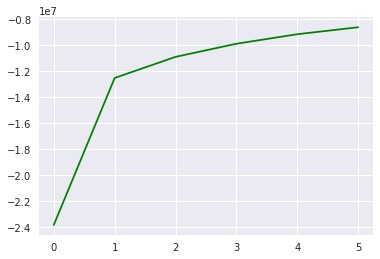

In [122]:
results = [
    -23825914.2352, # 2 clusters 
    -12518129.722, # 10 clusters
    -10893182.9713, # 15 clusters
    -9883947.64045, # 20 clusters
    -9151185.22466, # 25 clusters
    -8614428.29378 # 30 clusters
]

plt.plot(results, color="g");

5: -1066499.33357
10: -798016.763098
12: -747378.824158
15: -694746.968323
17: -665089.961509
20: -630644.817028
22: -608391.51166
25: -585000.458367
27: -571325.344752
30: -551330.294425


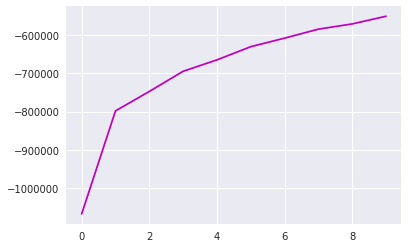

In [118]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

random_index = np.random.choice(np.arange(data_pca.shape[0]), 30000)
remix = data_pca[random_index, :]

scores = []

for i in [5, 10, 12, 15, 17, 20, 22, 25, 27, 30]:
    model = KMeans(i, random_state=42)
    labels = model.fit_predict(remix)
    
    score_ = model.score(remix)
    print("{}:".format(i), score_)
    
    scores.append(score_)

plt.plot(scores, color="m");

In [72]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

model = KMeans(18, random_state=42)
labels = model.fit_predict(data_pca)

### Discussion 3.1: Apply Clustering to General Population

The initial approach here was to apply a different number (within the [10, 30] range) of clusters to our entire PCA transformed dataset. The results were preserved in the cells above, with the `model_i` assigment.

We can see, as expected, that the scores increases as the number of clusters increases, but with diminishing returns.

This initial approach gave us the information we need, but we could still try some more configurations of clusters. To increase processing speed, a random reduced sample of a specific size was taken from the dataset and then the clustering was done on the reduced dataset.

The reduced dataset showed a very similar behaviour in terms of cluster scores, even when varying the size of the subset (the final cell produces a subset with 30,000 rows, however 25,000 and 50,000 were also tested). Obviously, the scores were different. But the rate of change was very similar, showing that we could use the reduced dataset to attempt more cluster settings, with increased performance.

In the end, **18** was the selected number of clusters to go on with our analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [135]:
# Load in the customer demographics data.
customers = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=";")

# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers, feat_info)

c_data = imp.transform(customers_clean)
c_data = scaler.transform(c_data)
c_data = pca.transform(c_data)
c_labels = model.predict(c_data)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [124]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [112]:
def get_labels_freq(labels):
    """
    Shows frequency and count of clusters
    
    Input:
        labels: a 1D numpy array with labels obtained form a clustering
    Output:
        3D numpy array with the count and % of total of each cluster
    """
    
    unique, count = np.unique(labels, return_counts=True)
    
    unique = unique.reshape(len(unique), 1)
    count = count.reshape((len(count), 1))
    
    share = count[:,0] / count[:,0].sum()
    share = share.reshape((len(share), 1))
    
    result = np.concatenate([unique, count, share],
                            axis=1)

    return result

In [114]:
def get_df_from_labels(labels):
    """
    Creates a DataFrame of clusters,
    showing the count and % of total of each cluster
    
    Input:
        labels: a 1D numpy array with labels obtained form a clustering
    Output:
        DataFrame with the count and % of total of each cluster
    """
    
    labels = get_labels_freq(labels)
    cols = ["cluster", "count", "share"]

    return pd.DataFrame(labels, columns = cols)    

In [189]:
# data with too much missing values: demographic

rare_set.shape[0], rare_set.shape[0] / azdias.shape[0]

(109175, 0.12250047967900218)

In [190]:
# data with too much missing values: demographic

c_diff = customers.shape[0] - customers_clean.shape[0]
c_diff, c_diff / customers.shape[0]

(52228, 0.2725147663473379)

In [179]:
# data frame building

demo_labels_df = get_df_from_labels(labels)
demo_labels_df["type"] = "demographic"

customer_labels_df = get_df_from_labels(c_labels)
customer_labels_df["type"] = "customer"

comp_df = pd.concat([demo_labels_df,
                     customer_labels_df])

comp_df = comp_df.reset_index(drop=True)
# avoid duplicated index, as we have concataned dataframes

comp_df.loc[36,["cluster", "count", "share", "type"]] = [18.0, 109175, 0.1225, "demographic"]
comp_df.loc[37,["cluster", "count", "share", "type"]] = [18.0, 52228, 0.2725, "customer"]
comp_df

,cluster,count,share,type
0,0.0,48984.0,0.062636,demographic
1,1.0,43132.0,0.055153,demographic
2,2.0,47288.0,0.060467,demographic
3,3.0,35832.0,0.045818,demographic
4,4.0,41245.0,0.052740,demographic
5,5.0,56321.0,0.072018,demographic
6,6.0,50825.0,0.064990,demographic
7,7.0,45310.0,0.057938,demographic
8,8.0,45049.0,0.057604,demographic
9,9.0,35109.0,0.044894,demographic


Note: cluster


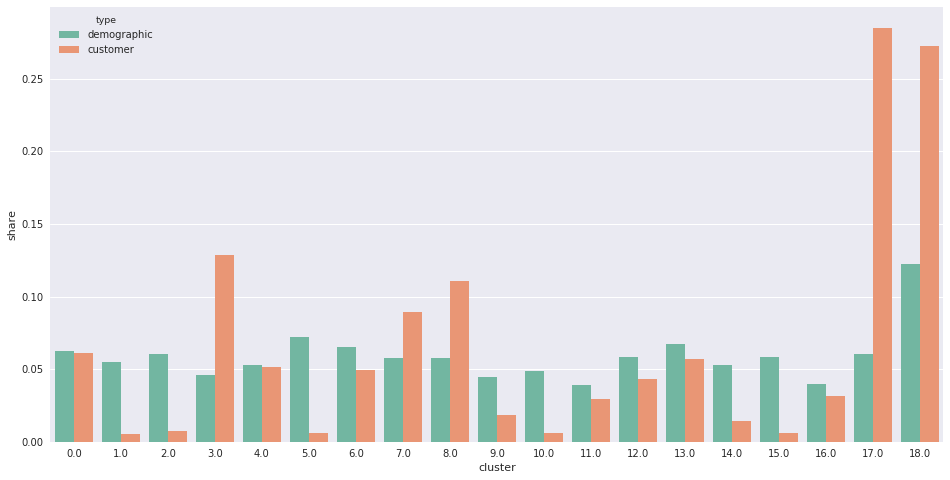

In [181]:
# plot

plt.figure(figsize=(16,8))

sns.barplot(x=comp_df["cluster"],
            y=comp_df["share"],
            palette="Set2",
            data=comp_df,
            hue="type");

NOTE: cluster **18** is the "cluster" of the subset with too much missing data.

In [ ]:
# clusters to look at:
# overrepresented:
17, 3

#underrepresented
1, 15

In [186]:
people = pd.DataFrame(c_data)
people["label"] = c_labels
people.describe()

,0,1,2,3,4,5,6,7,label
count,139424.000000,139424.000000,139424.000000,139424.000000,139424.000000,139424.000000,139424.000000,139424.000000,139424.000000
mean,-2.431256,1.529267,1.407542,1.031471,0.093389,0.327221,0.001142,-0.228512,9.898475
std,2.891607,2.171051,2.240633,2.117691,1.536286,1.536214,1.400628,1.365714,5.792490
min,-8.091513,-7.533668,-4.605314,-5.692353,-5.859038,-4.518824,-3.989789,-5.754134,0.000000
25%,-4.618099,0.267475,-0.951831,-0.667315,-0.938834,-0.804964,-0.861592,-1.167311,4.000000
50%,-3.254526,1.548807,2.198941,1.046752,0.107522,0.315751,-0.062898,-0.161680,8.000000
75%,-0.721801,2.920916,3.206369,2.754424,1.158403,1.399218,0.741422,0.755667,17.000000
max,10.871839,10.205326,6.289241,9.462379,6.673254,15.047777,24.824958,7.758982,17.000000


In [187]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

mask = people["label"] == 17
people[mask].describe()

,0,1,2,3,4,5,6,7,label
count,39744.000000,39744.000000,39744.000000,39744.000000,39744.000000,39744.000000,39744.000000,39744.000000,39744.0
mean,-3.508023,1.172785,3.258410,2.839513,-0.049294,-0.111422,0.029105,-0.541110,17.0
std,1.500436,1.219457,0.815360,1.173406,1.393106,1.414600,1.068835,1.449438,0.0
min,-7.837356,-3.698111,-0.026689,-0.601339,-5.030508,-4.246396,-3.320296,-5.146026,17.0
25%,-4.609194,0.448540,2.683327,2.008706,-0.991038,-1.189850,-0.716552,-1.654390,17.0
50%,-3.666060,1.278506,3.303431,2.860645,-0.010361,-0.101845,0.013505,-0.617447,17.0
75%,-2.531602,2.025817,3.872922,3.665772,0.932249,0.925299,0.735251,0.549527,17.0
max,2.381657,5.095956,6.271548,9.462379,5.089419,5.419060,5.715405,4.061098,17.0


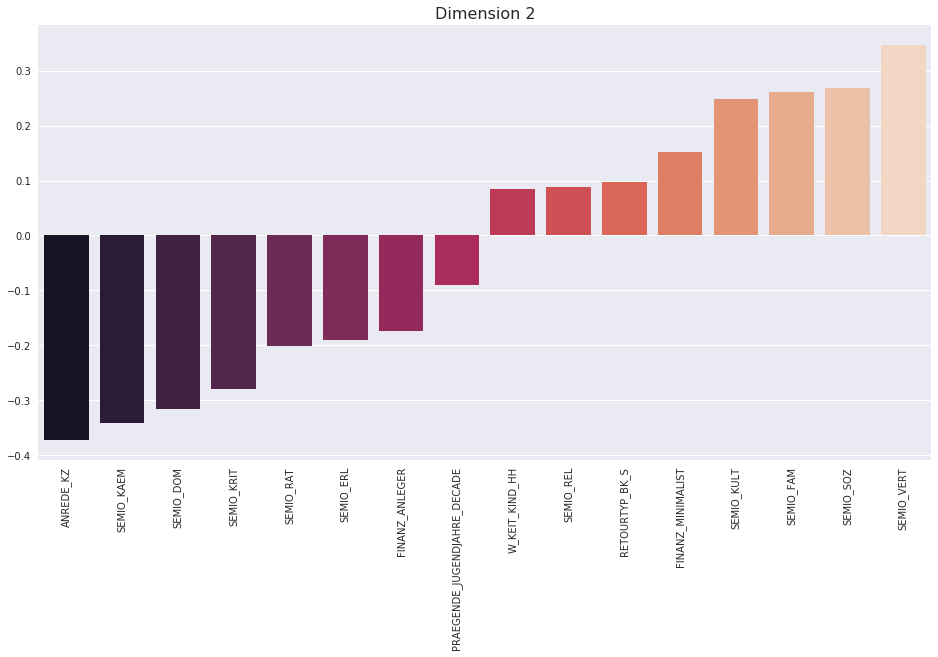

In [193]:
# component 2 and 3 seem to be the most significants
# let's have a look on their composition

show_pca_dim(pca, dense_set, 2)

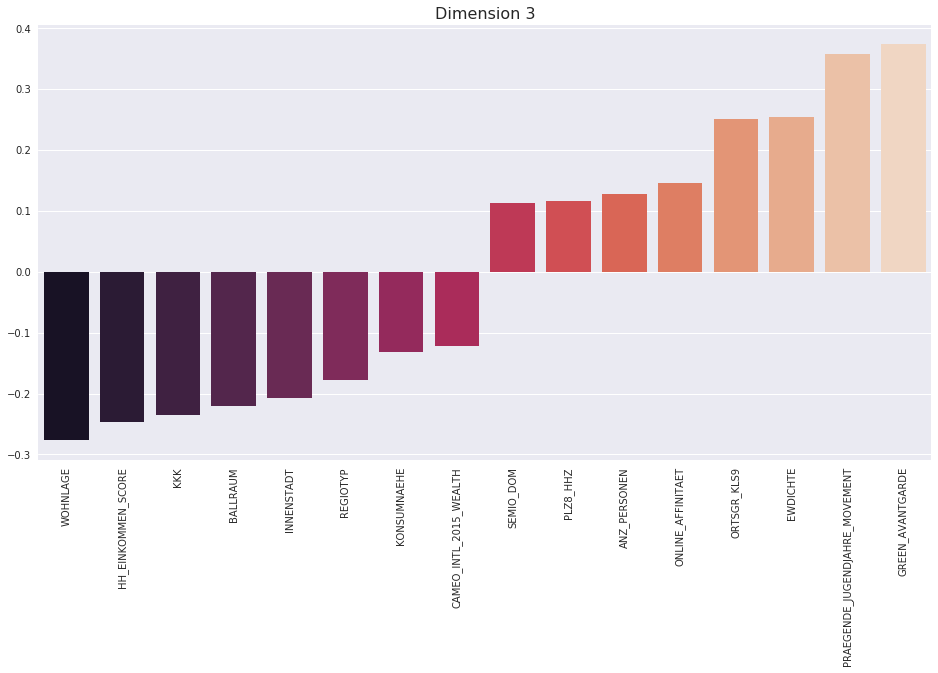

In [194]:
show_pca_dim(pca, dense_set, 3)

In [196]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

mask = people["label"] == 10
people[mask].describe()

,0,1,2,3,4,5,6,7,label
count,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.000000,828.0
mean,4.889372,-1.768165,3.046776,1.198420,0.744345,0.353943,0.501997,0.100624,10.0
std,1.141834,1.231075,1.093157,1.535285,1.280960,1.395721,1.615861,1.418684,0.0
min,1.306681,-4.732421,0.425196,-2.126244,-3.167740,-3.064567,-3.276534,-4.733441,10.0
25%,4.072641,-2.770240,2.261840,0.122029,-0.095631,-0.702762,-0.667294,-0.843490,10.0
50%,5.011612,-1.692622,3.183437,0.854165,0.732298,0.199572,0.379638,0.203857,10.0
75%,5.704126,-0.679121,3.827085,2.190516,1.663429,1.382058,1.538921,1.111380,10.0
max,7.691650,0.758565,5.513689,5.733448,4.492108,4.469911,5.964029,3.313837,10.0


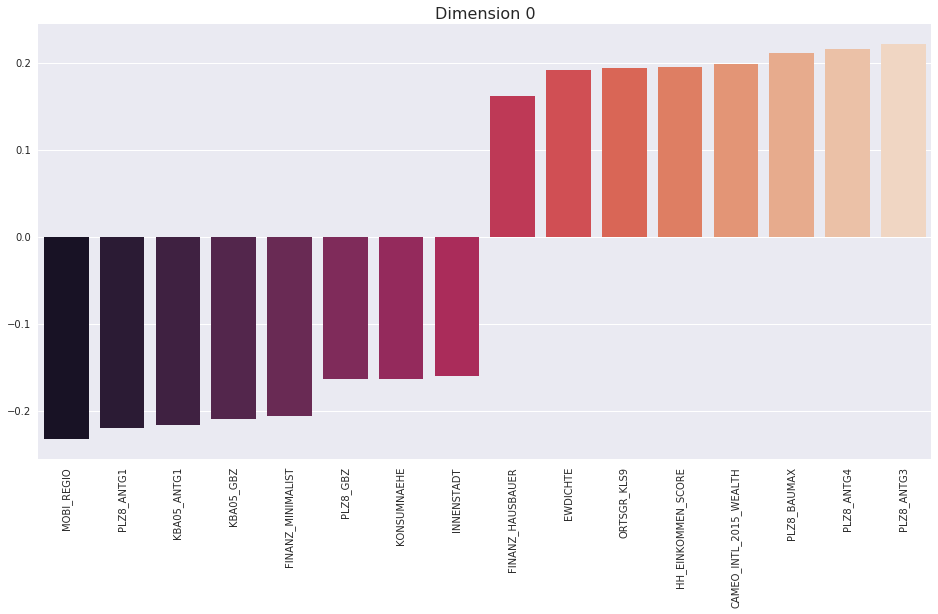

In [198]:
show_pca_dim(pca, dense_set, 0)

### Discussion 3.3: Compare Customer Data to Demographics Data

There are some great differences amongst the clustering of the demographic data and the clustering of the customer data. We see some huge differences in proportions for certain clusters, suggesting that the company's target audience may be well outlined from the demographic data.

#### Clusters with higher proportions

We see that the customer data has higher proportions for the clusters **3, 7, 8, 17 and 18**. Notice that we are refering to the clusters in a 0-index manner, and that the cluster 18 is actually the separated subset of rows with too much missing data.

Investigating **cluster 17** (the most discrepant), we can see that **components 2 and 3** are the most significant. In the **component 2**, we verify correlations between the `SEMIO_*` features. These features talk about the **personality** of the individual. **In this dimension, _lower_ values mean _greater_ affinity**.

We check **higher weights** on `SEMIO_VERT` and `SEMIO_SOZ`, that indicate, respectively, _dreamful_ and _socially-minded_. On the other hand, we have **negative weights** on `SEMIO_KAEM` and `SEMIO_DOM`, these being _combative attitude_ and _dominant-minded_.

The **component 3** has a mix of seemingly unrelated features. The **positive weights** are on `GREEN_AVANTGARDE` (_"membership in environmental sustainability as part of youth"_, according to the Data Dictionary, `1` being `member` and 0 being `not a member`) and `PRAEGENDE_JUGENDJAHRE_MOVEMENT`, which is the `movement` meaning distangled from the `PRAEGENDE_JUGENDJAHRE` feature. For this feature, that is the result of a data engineering process applyed in the begginig of this notebook, two values are possible: `0` for `mainstrem` and `1` for `avantgarde`.

The **negative weights** of this component are on the `WOHNLAGE` (_"neighborhood quality"_) and `HH_EINKOMMEN_SCORE` (_"estimated household net income"_). For both of these features, a _low_ score indicate a _better quality/greater income_. So even tought the weights are negative, we are talking about good economic conditions.

Putting together the analysis of these two components, we can infer that the company's customers are individuals with **better economic conditions** and are **less open-minded, with a more competitive mindset**.

#### Clusters with lower proportions

Clusters **1, 2, 5, 10 and 15** have significantly lower proportions. That is, they are less popular with the company.

Looking **cluster 10** in detail, the **component 2** (the competitive and less open-minded individuals) makes a presence again, being the second most significant. The **component 0** is the most proeminent one.

Its **positive weights** are on `PLZ8_ANTG4` (_"number of 10+ family houses in the PLZ8 region"_) and `PLZ8_ANTG3` (_"number of 6-10 family houses in the PLZ8 region"_). For these features, the higher the score, the more families are in the region. The **negative weights** rests on `MOBI_REGION` ("movement patterns", a _low_ score indicating _high_ movement) and `PLZ8_ANTG1` (_"number of 1-2 family houses in the PLZ8 region").

The combination of these features inform us that the company's customers **tend to _not_ live in crowded areas**. This again reinforces the idea that the company targets wealthier individuals, as shown in the previous section.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.